[I 2023-12-29 12:38:45,469] A new study created in memory with name: no-name-29e51fd5-b9ce-4d2b-82ca-21c0bdc67a8d
[I 2023-12-29 12:38:45,474] Trial 0 finished with value: -0.5176718179434752 and parameters: {'alpha': 650529.9089564747}. Best is trial 0 with value: -0.5176718179434752.
[I 2023-12-29 12:38:45,477] Trial 1 finished with value: -0.5159872468201221 and parameters: {'alpha': 44451.5387818986}. Best is trial 1 with value: -0.5159872468201221.
[I 2023-12-29 12:38:45,481] Trial 2 finished with value: -0.5176683263209745 and parameters: {'alpha': 632745.7613544466}. Best is trial 1 with value: -0.5159872468201221.
[I 2023-12-29 12:38:45,489] Trial 3 finished with value: -0.5176583729947053 and parameters: {'alpha': 586998.7366443746}. Best is trial 1 with value: -0.5159872468201221.
[I 2023-12-29 12:38:45,493] Trial 4 finished with value: -0.5177088652128543 and parameters: {'alpha': 926915.8258169962}. Best is trial 1 with value: -0.5159872468201221.
[I 2023-12-29 12:38:45,498]

Best Parameters: {'alpha': 153.42029089726532}
Średni błąd kwadratowy (MSE): 221.4942078560865
Procentowa zgodność: -36.24%


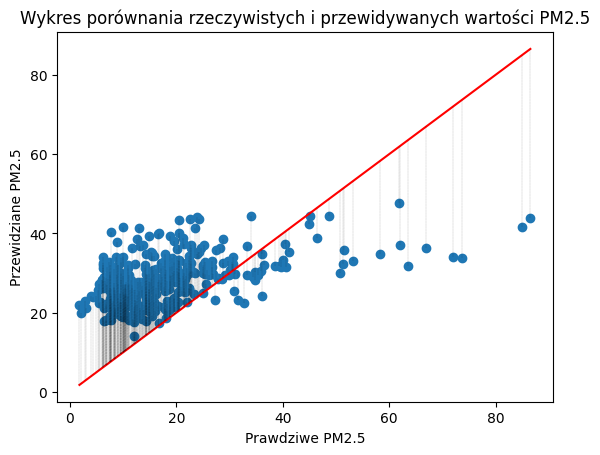

Średni błąd kwadratowy (MSE): 122.07597031146793
r2 score: -262.91%


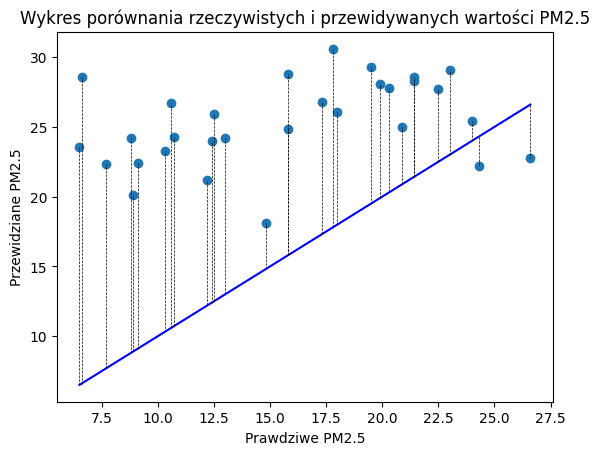

[I 2023-12-29 12:38:58,476] A new study created in memory with name: no-name-b7d58201-40bc-4d2a-8424-ee99ac78b814
[I 2023-12-29 12:38:58,483] Trial 0 finished with value: -0.03015384757020434 and parameters: {'alpha': 939033.46753686}. Best is trial 0 with value: -0.03015384757020434.
[I 2023-12-29 12:38:58,486] Trial 1 finished with value: -0.03016010739748798 and parameters: {'alpha': 979551.9412778517}. Best is trial 0 with value: -0.03015384757020434.
[I 2023-12-29 12:38:58,486] Trial 2 finished with value: -0.030152803168145725 and parameters: {'alpha': 932597.276526114}. Best is trial 2 with value: -0.030152803168145725.
[I 2023-12-29 12:38:58,486] Trial 3 finished with value: -0.030049812481159677 and parameters: {'alpha': 556449.7380540855}. Best is trial 3 with value: -0.030049812481159677.
[I 2023-12-29 12:38:58,486] Trial 4 finished with value: -0.030148723803566035 and parameters: {'alpha': 908281.0829100412}. Best is trial 3 with value: -0.030049812481159677.
[I 2023-12-29

Best Parameters: {'alpha': 6.390758739609957}
Średni błąd kwadratowy (MSE): 170.51179484534228
Procentowa zgodność: 72.93%


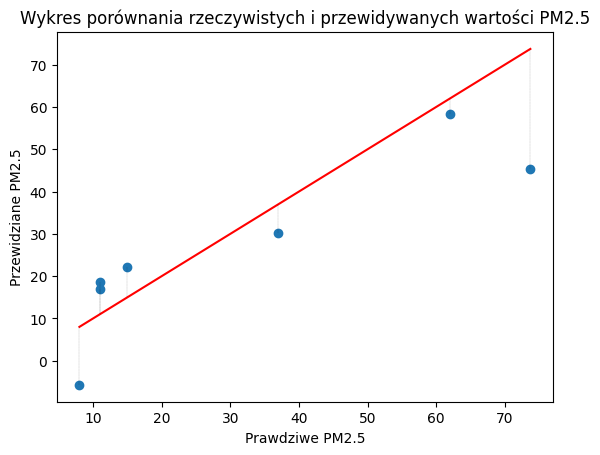

Średni błąd kwadratowy (MSE): 92.78171623055886
r2 score: -175.82%


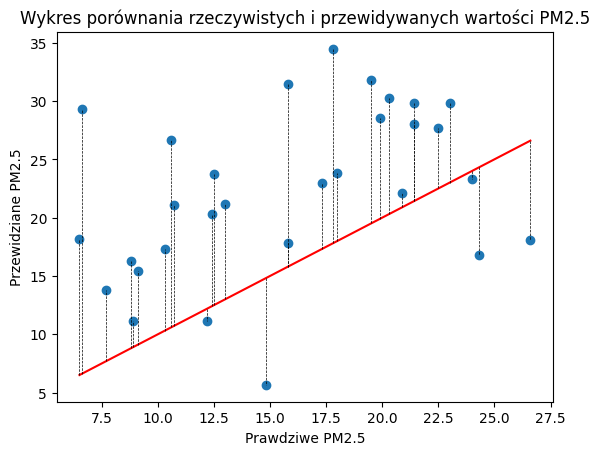

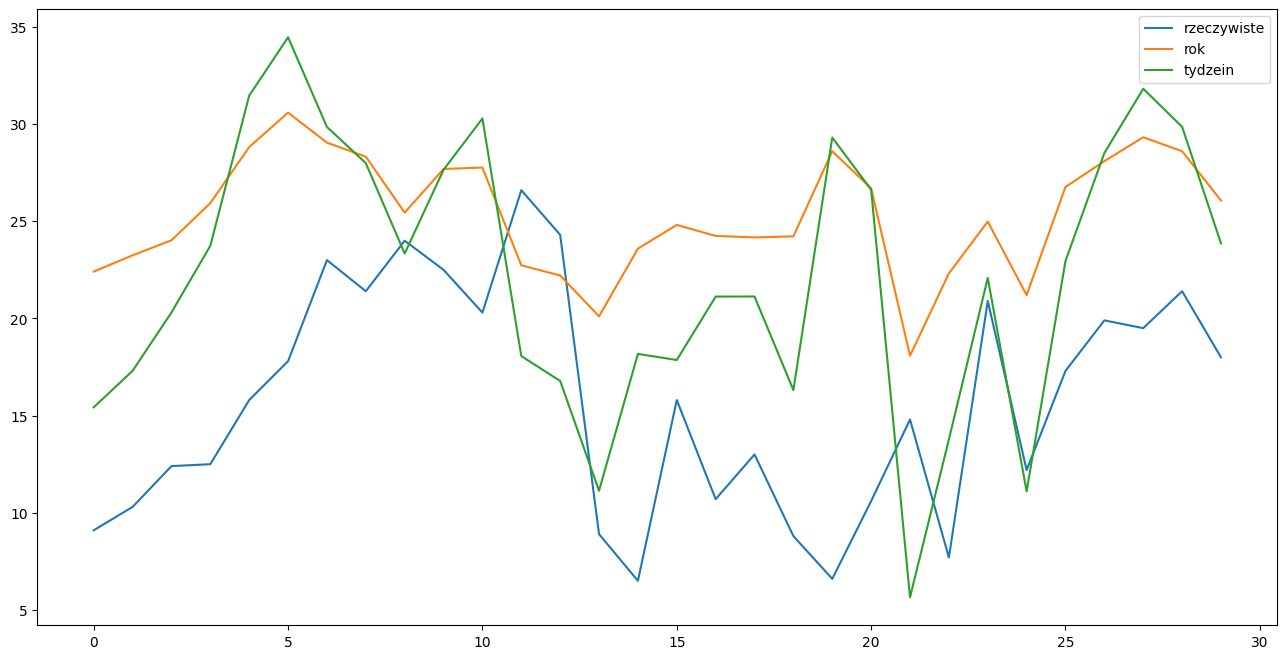

Procent dobrze przewidzianych kategorii (zbiór testowy rok): 56.67%


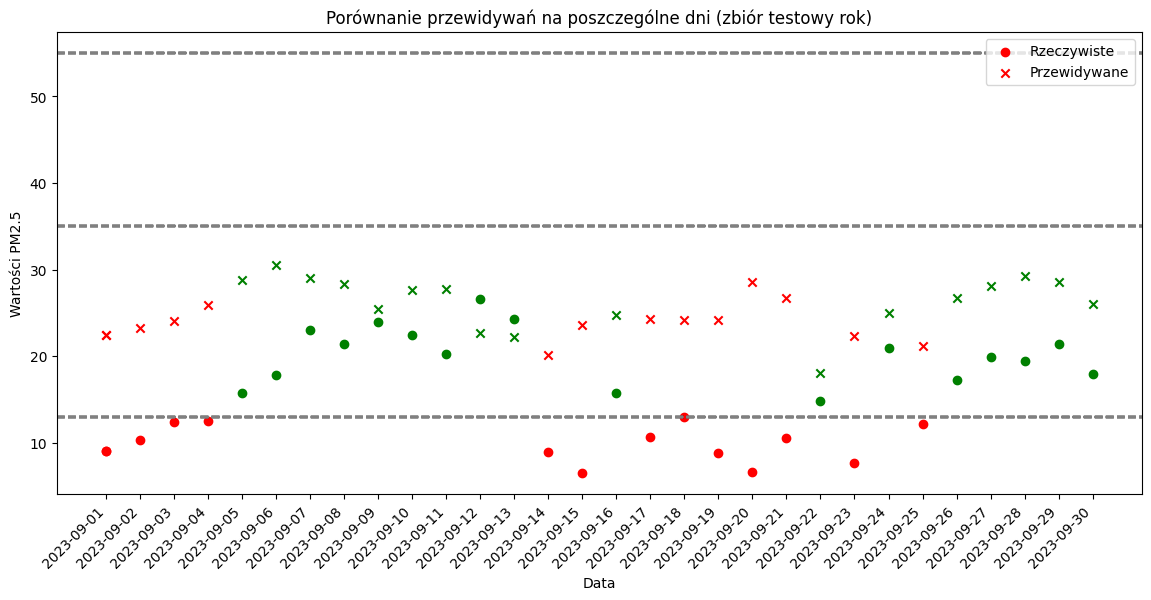

skuteczność:
Procent dobrze przewidzianych kategorii (zbiór testowy tydzień): 60.00%


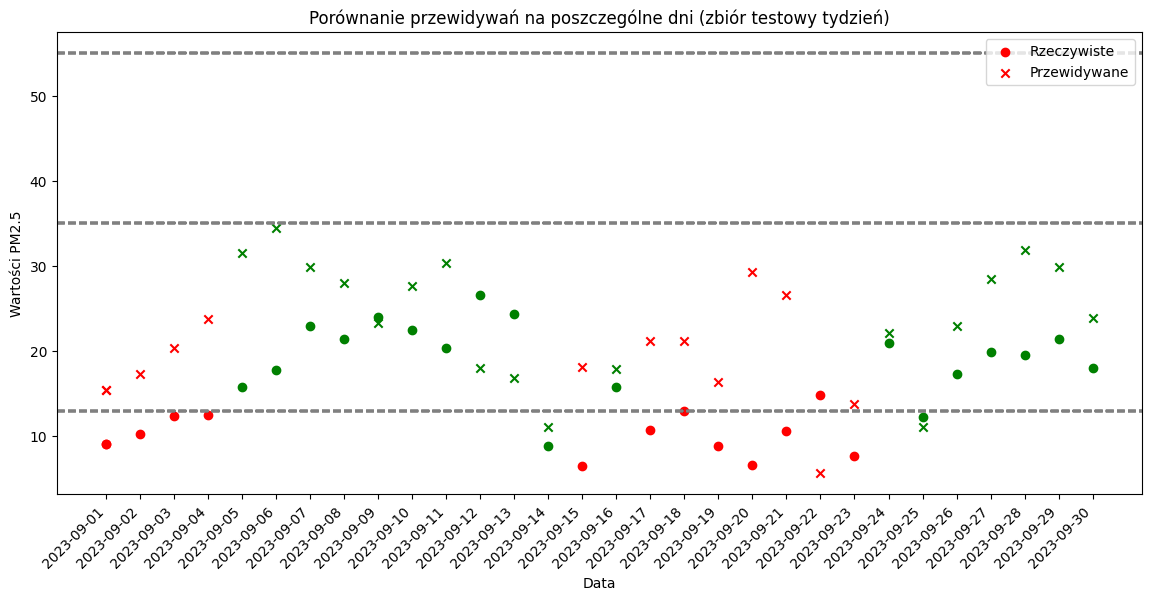

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.patches as mpatches
import seaborn as sns

model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,shuffle=False)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def objective(trial):
    alpha = trial.suggest_float('alpha', 0.001, 1000000.0)

    model = Ridge(alpha=alpha,random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize') 
stale_count = 0

best_r2 = -float('inf')

r2_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value > best_r2:
        best_r2 = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    r2_values.append(best_r2)

    if stale_count >= 1000 or best_r2 >= 1.0:
        break

best_params = study.best_params
best_r2 = study.best_value

print("Best Parameters:", best_params)



model = Ridge(**best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]],'k--', lw=0.1)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = abs(results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)'])
results.sort_values('Różnica')

model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
model_data_test.index = pd.RangeIndex(start=3487, stop=3517, step=1)
model_data_test
X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']
X_test_test_scaled = scaler.transform(X_test_test)

y_pred_test = model.predict(X_test_test_scaled)
mse = mean_squared_error(y_test_test, y_pred_test)
r2 = r2_score(y_test_test, y_pred_test)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"r2 score: {percent_match:.2f}%")

y_test_test = y_test_test.reset_index(drop=True)
plt.plot([min(y_test_test), max(y_test_test)], [min(y_test_test), max(y_test_test)], 'b', label='y=x')
plt.scatter(y_test_test, y_pred_test)
for i in range(len(y_test_test)):
    plt.plot([y_test_test[i], y_test_test[i]], [y_test_test[i], y_pred_test[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()



model_data = pd.read_csv("../../przygotowanie_danych/model_data.csv")
X = model_data[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y = model_data['PM2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.002,random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


def objective(trial):
    alpha = trial.suggest_float('alpha', 0.001, 1000000.0)

    model = Ridge(alpha=alpha,random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    r2 = r2_score(y_test, y_pred)

    return r2

study = optuna.create_study(direction='maximize') 
stale_count = 0

best_r2 = -float('inf')

r2_values = []

for _ in range(11000):
    study.optimize(objective, n_trials=1)

    if study.best_value > best_r2:
        best_r2 = study.best_value
        stale_count = 0
    else:
        stale_count += 1

    r2_values.append(best_r2)

    if stale_count >= 1000 or best_r2 >= 1.0:
        break

best_params = study.best_params
best_r2 = study.best_value

print("Best Parameters:", best_params)




model = Ridge(**best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"Procentowa zgodność: {percent_match:.2f}%")

y_test = y_test.reset_index(drop=True)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='y=x')
plt.scatter(y_test, y_pred)
for i in range(len(y_test)):
    plt.plot([y_test[i], y_test[i]], [y_test[i], y_pred[i]],'k--', lw=0.1)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

results = pd.DataFrame({'Rzeczywiste wartości (y_test)': y_test, 'Przewidywane wartości (y_pred)': y_pred})
results['Różnica'] = abs(results['Rzeczywiste wartości (y_test)'] - results['Przewidywane wartości (y_pred)'])
results.sort_values('Różnica')

model_data_test = pd.read_csv("../../przygotowanie_danych/model_data_test.csv")
model_data_test.index = pd.RangeIndex(start=3487, stop=3517, step=1)
model_data_test
X_test_test = model_data_test[["temperatura", "suma opadów", "wilgotność", "prędkość wiatru", "zachmurzenine", "day_number_in_year"]]
y_test_test = model_data_test['PM2.5']
X_test_test_scaled = scaler.transform(X_test_test)


y_pred_test_2 = model.predict(X_test_test_scaled)
mse = mean_squared_error(y_test_test, y_pred_test_2)
r2 = r2_score(y_test_test, y_pred_test_2)

print(f"Średni błąd kwadratowy (MSE): {mse}")
percent_match = r2 * 100
print(f"r2 score: {percent_match:.2f}%")

y_test_test = y_test_test.reset_index(drop=True)
plt.plot([min(y_test_test), max(y_test_test)], [min(y_test_test), max(y_test_test)],'r', label='y=x')
plt.scatter(y_test_test, y_pred_test_2)
for i in range(len(y_test_test)):
    plt.plot([y_test_test[i], y_test_test[i]], [y_test_test[i], y_pred_test_2[i]], 'k--', lw=0.5)
plt.xlabel("Prawdziwe PM2.5")
plt.ylabel("Przewidziane PM2.5")
plt.title("Wykres porównania rzeczywistych i przewidywanych wartości PM2.5")
plt.show()

plt.figure(figsize=[16,8])
plt.plot(y_test_test,label="rzeczywiste")
plt.plot(y_pred_test,label="rok")
plt.plot(y_pred_test_2,label="tydzein")
plt.legend()
plt.show()
def ocen_jakosc_powietrza(rzeczywiste, przewidywane):
    prog_bardzo_dobry = 13
    prog_dobry = 35
    prog_umiarkowany = 55
    prog_dostateczny = 75
    prog_zly = 110

    kategorie = {
        'bardzo_dobry': (0, prog_bardzo_dobry),
        'dobry': (prog_bardzo_dobry + 0.1, prog_dobry),
        'umiarkowany': (prog_dobry + 0.1, prog_umiarkowany),
        'dostateczny': (prog_umiarkowany + 0.1, prog_dostateczny),
        'zly': (prog_dostateczny + 0.1, prog_zly),
        'bardzo_zly': (prog_zly + 0.1, float('inf'))
    }

    def przyporzadkuj_kategorie(wartosc):
        for kategoria, (min_prog, max_prog) in kategorie.items():
            if min_prog <= wartosc <= max_prog:
                return kategoria

    rzeczywista_kategoria = przyporzadkuj_kategorie(rzeczywiste)
    przewidziana_kategoria = przyporzadkuj_kategorie(przewidywane)

    return rzeczywista_kategoria, przewidziana_kategoria


# Przykładowe dane - zastąp tym odpowiednimi danymi
results = pd.DataFrame({
    'Data': pd.date_range(start='2023-09-01', periods=30),
    'Rzeczywiste wartości (y_test)': y_test_test,
    'Przewidywane wartości (y_pred)': y_pred_test
})

# Dodaj kolumny kategorii i porównania
results['Rzeczywista kategoria'], results['Przewidziana kategoria'] = zip(*results.apply(lambda row: ocen_jakosc_powietrza(row['Rzeczywiste wartości (y_test)'], row['Przewidywane wartości (y_pred)']), axis=1))
results['Zgadza się'] = results['Rzeczywista kategoria'] == results['Przewidziana kategoria']
legend_added = False  # Dodaj legendę tylko raz

# Wyodrębnij unikalne daty
unikalne_daty = results['Data'].unique()


procent_poprawnych = results['Zgadza się'].mean() * 100
print(f"Procent dobrze przewidzianych kategorii (zbiór testowy rok): {procent_poprawnych:.2f}%")


plt.figure(figsize=(14, 6))
sns.set_palette("Set2")  # Wybierz zestaw kolorów
for data in unikalne_daty:
    dane_dnia = results[results['Data'] == data]
    color = 'green' if dane_dnia['Zgadza się'].all() else 'red'
    
    
    if not legend_added:
        
        plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'],label='Rzeczywiste', color=color, marker='o')
        plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'], label='Przewidywane',color=color, marker='x')
        legend_added = True

    plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'], color=color, marker='o')
    plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'],color=color, marker='x')

    progi_jakosci_powietrza = [13, 35, 55]
    for prog in progi_jakosci_powietrza:
        plt.axhline(y=prog, color='gray', linestyle='--')
plt.legend(loc='upper right')
plt.title('Porównanie przewidywań na poszczególne dni (zbiór testowy rok)')
plt.xlabel('Data')
plt.ylabel('Wartości PM2.5')
plt.xticks(ticks=unikalne_daty, labels=[data.strftime('%Y-%m-%d') for data in unikalne_daty], rotation=45, ha='right')
plt.show()
print("skuteczność:",)



# Przykładowe dane - zastąp tym odpowiednimi danymi
results = pd.DataFrame({
    'Data': pd.date_range(start='2023-09-01', periods=30),
    'Rzeczywiste wartości (y_test)': y_test_test,
    'Przewidywane wartości (y_pred)': y_pred_test_2
})

# Dodaj kolumny kategorii i porównania
results['Rzeczywista kategoria'], results['Przewidziana kategoria'] = zip(*results.apply(lambda row: ocen_jakosc_powietrza(row['Rzeczywiste wartości (y_test)'], row['Przewidywane wartości (y_pred)']), axis=1))
results['Zgadza się'] = results['Rzeczywista kategoria'] == results['Przewidziana kategoria']
legend_added = False  # Dodaj legendę tylko raz

# Wyodrębnij unikalne daty
unikalne_daty = results['Data'].unique()

procent_poprawnych = results['Zgadza się'].mean() * 100
print(f"Procent dobrze przewidzianych kategorii (zbiór testowy tydzień): {procent_poprawnych:.2f}%")

plt.figure(figsize=(14, 6))
sns.set_palette("Set2")  # Wybierz zestaw kolorów
for data in unikalne_daty:
    dane_dnia = results[results['Data'] == data]
    color = 'green' if dane_dnia['Zgadza się'].all() else 'red'
    
    
    if not legend_added:
        
        plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'],label='Rzeczywiste', color=color, marker='o')
        plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'], label='Przewidywane',color=color, marker='x')
        legend_added = True

    plt.scatter([data]*len(dane_dnia), dane_dnia['Rzeczywiste wartości (y_test)'], color=color, marker='o')
    plt.scatter([data]*len(dane_dnia), dane_dnia['Przewidywane wartości (y_pred)'],color=color, marker='x')

    progi_jakosci_powietrza = [13, 35, 55]
    for prog in progi_jakosci_powietrza:
        plt.axhline(y=prog, color='gray', linestyle='--')
plt.legend(loc='upper right')
plt.title('Porównanie przewidywań na poszczególne dni (zbiór testowy tydzień)')
plt.xlabel('Data')
plt.ylabel('Wartości PM2.5')
plt.xticks(ticks=unikalne_daty, labels=[data.strftime('%Y-%m-%d') for data in unikalne_daty], rotation=45, ha='right')
plt.show()